In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Objectives 

1. The customer who bought the most items overall in her lifetime
2. For each item, the customer who bought that product the most
3. Cluster items based on user co-purchase history.

**Merge table and clean data**

In [2]:
#load data
item = pd.read_csv("item_to_id.csv")
user = pd.read_csv("purchase_history.csv")
cluster_user = user.copy()
print("unique items: ", item.shape)
print("total number of transactions: ", user.shape)
print("unique users: ", len(user['user_id'].unique()))

item table has shape:  (48, 2)
user table has shape:  (39474, 2)


In [3]:
#clean user table by removing ',' in id column and separate items by id
user = pd.DataFrame(user.id.str.split(',').tolist(), index = user.user_id).stack()
user = user.reset_index()[[0, 'user_id']]
user.columns = ['id', 'user_id']
user['id'] = user['id'].astype('int')
item['Item_id'] =item['Item_id'].astype('int')

In [4]:
data = pd.merge(user, item, left_on = 'id', right_on = 'Item_id')
data.drop('id', axis = 1, inplace = True)
data.head()

,user_id,Item_name,Item_id
0,222087,dishwashing,27
1,404134,dishwashing,27
2,987613,dishwashing,27
3,60201,dishwashing,27
4,1166671,dishwashing,27


Data explorations
1. Most users have bought between 1-20 products
2. Item bought most by users is *Lettuce*, and item bought by least amount of users is *flour*

Text(0.5,1,'number of products users purchase')

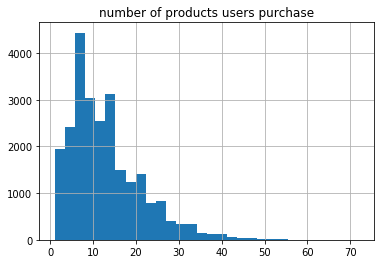

In [5]:
user = data.groupby('user_id')['Item_name'].count()
user.hist(bins = 30)
plt.title("number of products users purchase")

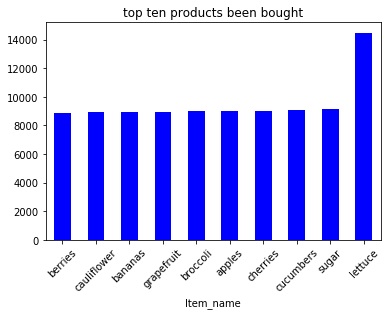

In [6]:
product = data.groupby('Item_name')['user_id'].count().sort_values()
product[-10:].plot(kind='bar',color = 'b',title ='top ten products been bought', rot = 45)

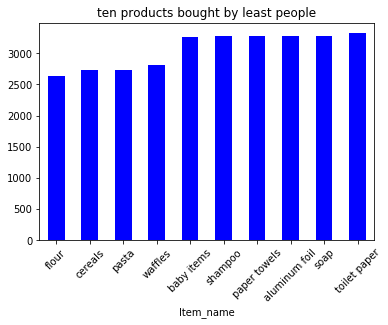

In [7]:
product[:10].plot(kind = 'bar', color = 'b', title = 'ten products bought by least people', rot=45)

**user who bought the most items in her lifetime is 269335**

In [8]:
most_product_id = user[user.values == max(user)]
print("The user who bought most products is {}, and has bought {} items".format(most_product_id.index[0], most_product_id.values[0]))

The user who bought most products is 269335, and has bought 72 items


**For each item, the customer who bought that product the most**

In [54]:
item_most = data.groupby(['Item_name','user_id'])['user_id'].count()
item_most_id = item_most.unstack().idxmax(axis = 1)
item_dict = {"user":[], "item":[], "number":[]}
for prod in item_most_id.index:
    item_dict['user'].append(item_most_id[prod])
    item_dict['item'].append(prod)
    item_dict['number'].append(item_most[prod][item_most_id[prod]])
new_df = pd.DataFrame(item_dict)
new_df.head(5)

,item,number,user
0,aluminum foil,3,143741
1,apples,4,109578
2,baby items,3,5289
3,bagels,4,653800
4,bananas,4,1218645


**cluster based on co-purchase history**

In [28]:
#create a kxk matrix, and store cooccurence of item i and j into cell (i,j)
co_occur = np.zeros((len(item), len(item)))
for val in cluster_user.id:
    item_list = val.split(",")
    for i in range(len(item_list)):
        for j in range(i, len(item_list), 1):
            co_occur[int(item_list[i])-1, int(item_list[j])-1] += 1

In [48]:
#calculate the probability of co-occurence by dividing each row by its sum          
prob = co_occur / co_occur.sum(axis =1, keepdims=True)

#for each item, we find five items that 

In [50]:
sorted(prob[1], key = lambda x:-x)

[0.1768580296698194,
 0.029779798127917492,
 0.028997727106092823,
 0.028838868929784687,
 0.028692230613192562,
 0.025319549331573675,
 0.02362098883104822,
 0.023486570374172105,
 0.02303443556467972,
 0.022936676686951634,
 0.02285113766893956,
 0.02279003837035951,
 0.022765598650927487,
 0.022753378791211476,
 0.02255786103575531,
 0.02249676173717526,
 0.022447882298311215,
 0.022411222719163185,
 0.022374563140015152,
 0.022105726226262924,
 0.021885768751374733,
 0.02156805239875846,
 0.0214947332404624,
 0.01751105897304299,
 0.01699782486497055,
 0.016557909915194173,
 0.01617909426399785,
 0.01599579636825769,
 0.01593469706967764,
 0.015775838893369504,
 0.014981548011828823,
 0.014896008993816752,
 0.01488378913410074,
 0.014749370677224625,
 0.014700491238360584,
 0.009739228193660337,
 0.009311533103599971,
 0.009140455067575824,
 0.009079355768995772,
 0.009067135909279761,
 0.008834958574675563,
 0.00878607913581152,
 0.008456142923479239,
 0.008138426570862967,
 0.007